In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

###Import self-written library
import featexlib.debug as dbug
import featexlib.datagen as dgen

Out shape X,Y is: (10000, 256, 256) (10000, 256, 256)
Show first 10 images of X:


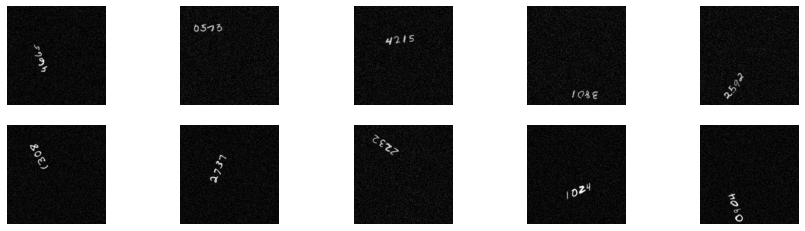

In [2]:
###Load data

x_load, y_load = dgen.Image_generator.load_data(name="base_unet_256x256_select_map")


###Show some report. Label is uniq for each class but it doesnt related to "real" image values
print("===================================")
print("Out shape X,Y is:",x_load.shape, y_load.shape)
print("Show first 10 images of X:")
dbug.Debug.show_images_list(x_load[:10], col_number = 5)

Show first 10 images of Y:


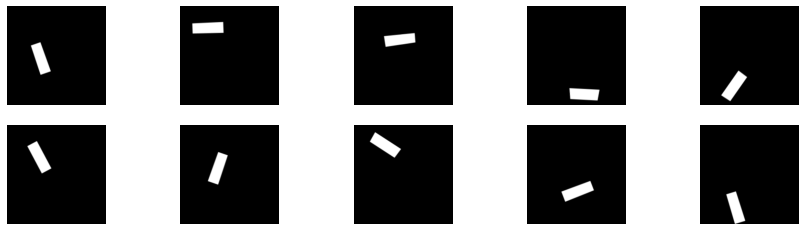

In [3]:
print("Show first 10 images of Y:")
dbug.Debug.show_images_list(y_load[:10], col_number = 5)

In [4]:
###Split data to test and train
n_train = 1000
n_test = 100
pic_h = x_load.shape[1]
pic_w = x_load.shape[2]
num_classes = 1

###Get X train and test
x_train, x_test = x_load[:n_train], x_load[n_train:n_train+n_test]
y_train, y_test = y_load[:n_train], y_load[n_train:n_train+n_test]

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_test.shape,y_test.shape)

###Clean memory
del x_load, y_load

===============Data is ready====================
Shape X,Y for train: (1000, 256, 256) (1000, 256, 256)
Shape X,Y for test:  (100, 256, 256) (100, 256, 256)


In [5]:
###Reshape and then rescale dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test  = scaler.transform(x_test.reshape(x_test.shape[0],-1))
y_train = y_train/255
y_test = y_test/255

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1000, 65536) (1000, 256, 256) (100, 65536) (100, 256, 256)


In [6]:
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train.astype('float32').reshape(-1,pic_h,pic_w,1)
xs = x_train.astype('float32').reshape(-1,pic_h,pic_w,1)
#ys_one_hot = tf.one_hot(ys, num_classes) ###not used

ys_test = y_test.reshape(-1,pic_h,pic_w,1)
xs_test = x_test.astype('float32').reshape(-1,pic_h,pic_w,1)

###Clear memory
del x_train, y_train, y_test, x_test
print(xs.shape, ys.shape, xs_test.shape, ys_test.shape)

(1000, 256, 256, 1) (1000, 256, 256, 1) (100, 256, 256, 1) (100, 256, 256, 1)


In [8]:
###Prepare model

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [9]:
model = unet()
model.fit(xs, ys, batch_size=10, epochs=1)

100/100 [==============================] - 3473s 35s/step - loss: 0.1310 - accuracy: 0.9463


In [10]:
y_pred = model(xs_test).numpy()

In [111]:
xs_test.max()

16.797413

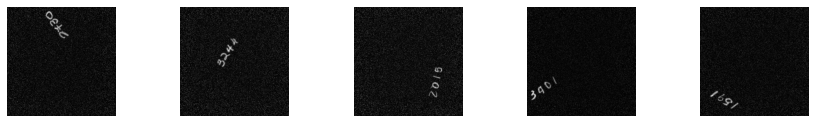

In [12]:
dbug.Debug.show_images_list(xs_test[:5].reshape(-1,pic_h,pic_w), col_number = 5)

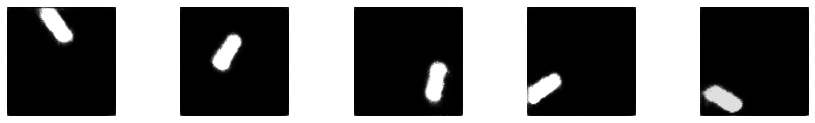

In [11]:
dbug.Debug.show_images_list(y_pred[:5].reshape(-1,pic_h,pic_w), col_number = 5)

1.8221087614927602 117.23287787668045


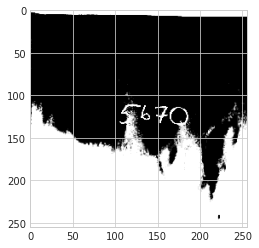

In [129]:
import cv2 as cv
img = cv.imread('Data/4dig/WIN_20200618_11_26_21_Pro.jpg', cv.IMREAD_UNCHANGED) 
t,l,h,w = 0,120,img.shape[0],img.shape[0]
img = img[t:t+h,l:l+w]
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_gray = cv.resize(img_gray, (256,256), interpolation = cv.INTER_AREA) 
img_gray = (255-img_gray)

mean, STD  = cv.meanStdDev(img_gray)
offset = 0.1
img_gray = np.clip(img_gray, mean - offset*STD, mean + offset*STD)

# Normalize to range
#result = cv.normalize(img_gray, img_gray, 0, 255, norm_type=cv.NORM_MINMAX)
print(img_gray.std(),img_gray.mean())
#dbug.Debug.show_image(img[:,:,[2,1,0]]) #for PIL format
dbug.Debug.show_image(img_gray)